In [1]:
from symbolfit.symbolfit import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


# Dataset

Five inputs are needed, which can be python lists or numpy arrays (more options will be added in future!):
1. ``x``: independent variable (bin center location).
2. ``y``: dependent variable.
3. ``y_up``: upward uncertainty in y per bin.
4. ``y_down``: downward uncertainty in y per bin.
5. ``bin_widths_1d`` bin widths in x.
- Elements in both y_up and y_down should be non-negative values.
- These values are the "delta" in y,
  - y + y_up = y shifted up by one standard deviation.
  - y - y_down = y shifted down by one standard deviation.
- If no uncertainty in the dataset, one can set both y_up and y_down to ones with the same shape as x.

In [2]:
x = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
y = [3.0, 2.2, 2.1, 2.05, 2, 2.1, 2.2, 1.9, 1.6]
y_up = [0.4, 0.3, 0.2, 0.2, 0.1, 0.05, 0.06, 0.1, 0.1]
y_down = [0.4, 0.3, 0.2, 0.2, 0.1, 0.05, 0.06, 0.1, 0.1]
bin_widths_1d = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

Plot the dataset to see what we will be fitting to:

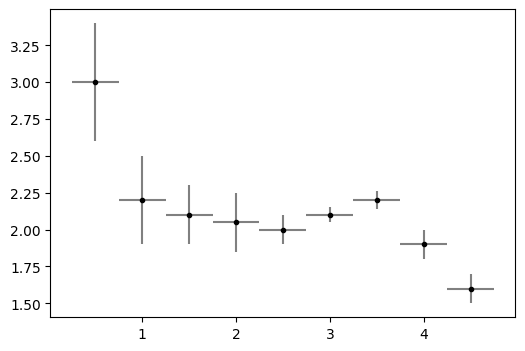

In [3]:
fig, axes = plt.subplots(figsize = (6, 4))
plt.errorbar(np.array(x).flatten(),
             np.array(y).flatten(),
             yerr = [np.array(y_down).flatten(), np.array(y_up).flatten()],
             xerr = np.array(bin_widths_1d)/2,
             fmt = '.', c = 'black', ecolor = 'grey', capsize = 0,
            )
plt.savefig('img/toy2a/dataset.png')

# Configure the fit

Configure PySR to define the function space being searched for with symbolic regression:

In [4]:
from pysr import PySRRegressor

pysr_config = PySRRegressor(
    model_selection = 'accuracy',
    niterations = 200,
    maxsize = 80,
    binary_operators = [
        '+', '*', '/', '^'
                     ],
    unary_operators = [
        'exp',
        'tanh',
    ],
    nested_constraints = {
        'exp':    {'exp': 0, 'tanh': 0, '*': 2, '/': 1, '^': 1},
        'tanh':   {'exp': 0, 'tanh': 0, '*': 2, '/': 1, '^': 1},
        '*':      {'exp': 1, 'tanh': 1, '*': 2, '/': 1, '^': 1},
        '^':      {'exp': 1, 'tanh': 1, '*': 2, '/': 1, '^': 0},
        '/':      {'exp': 1, 'tanh': 1, '*': 2, '/': 0, '^': 1},
    },
    loss='loss(y, y_pred, weights) = (y - y_pred)^2 * weights',
)

Here, we allow four binary operators (+, *, /, pow) and two unary operators (exp, tanh) when searching for functional forms.
The custom-defined gauss in the previous example may not be needed here since it this dataset is not obvious with a peak.

Nested constraints are imposed to prohibit, e.g., exp(exp(x))...

Loss function is a weighted MSE, where the weight is the sqaured uncertainty by default in SymbolFit.

For PySR options, please see:
- https://github.com/MilesCranmer/PySR
- https://astroautomata.com/PySR/

Configure SymbolFit with the PySR config and for the re-optimization process:

In [5]:
model = SymbolFit(
        # Dataset: x, y, y_up, y_down.
    	x = x,
    	y = y,
    	y_up = y_up,
    	y_down = y_down,
    
        # PySR configuration of the function space.
    	pysr_config = pysr_config,
    
        # Constrain the maximum function size and over-write maxsize in pysr_config.
        # Set a higher value for more complex shape, or when the lower one does not fit well.
    	max_complexity = 30,
    
        # Whether to scale input x to be within 0 and 1 for the fits for numerical stability,
        # as large x could lead to overflow when there is e.g. exp(x) -> exp(10000).
        # So set this to False when your x's are or close to O(1), otherwise recommended to set True.
        # After the fits, the functions will be unscaled to relect the original dataset.
    	input_rescale = False,
        # ^ no scaling needed here since the input x is O(1).
    
        # Whether to scale y for the fits for numerical stability,
        # options are (when input_rescale is True): None / 'mean' / 'max' / 'l2'.
        # This is useful to stabilize fits when your y's are very large or very small.
        # After the fits, the functions will be unscaled to relect the original dataset.
    	scale_y_by = None,
        # ^ no scaling needed here since the input y is O(1).
    
        # Set a maximum standard error (%) for all parameters to avoid bad fits during re-optimization.
        # In the refit loop, when any of the parameters returns a standard error larger than max_stderr,
        # the fit is considered failed, and the fit will retry itself for fewer or other combination of varying parameters,
        # by freezing some of the parameters to their initial values and kept fixed during re-optimization.
        # This is to avoid bad fits when the objective is too complex to minimize, which could cause some parameters
        # to have unrealistically large standard errors.
        # In most cases 10 < max_stderr < 100 suffices.
    	max_stderr = 20,
    
        # Consider y_up and y_down to weight the MSE loss during SR search and re-optimization.
    	fit_y_unc = True,
    
        # Set a random seed for returning the same batch of functional forms every time (single-threaded),
        # otherwise set None to explore more functions every time (multi-threaded and faster).
        # In most cases the function space is huge, one can retry the fits with the exact same fit configuration
        # and get completely different sets of candidate functions, merely by using different random seeds.
        # So if the candidate functions are not satisfactory this time, rerun it few times more with
        # random_seed = None or a different seed each time.
    	random_seed = None,
    
        # Custome loss weight to set "(y - y_pred)^2 * loss_weights", overwriting that with y_up and y_down.
    	loss_weights = None
)

# Symbol Fit it!

Run the fits: SR fit for functional form searching -> parameterization -> re-optimization fit for improved best-fits and uncertainty estimation -> evaluation.

In [6]:
model.fit()

Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 7.180e+05
Head worker occupation: 16.4%
Progress: 1457 / 3000 total iterations (48.567%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.752e-01  1.594e+01  y = 1.68
2           3.437e-02  1.629e+00  y = exp(0.72041)
5           2.267e-02  1.387e-01  y = (-0.15192 * x₀) + 2.5457
6           1.478e-02  4.280e-01  y = 2.2524 + (exp(x₀) * -0.0061958)
7           1.043e-02  3.484e-01  y = (-0.00062681 * (x₀ ^ x₀)) + 2.1433
8           1.021e-02  2.138e-02  y = (-5.2253e-07 * (exp(x₀) ^ 3.0764)) + 2.1265
10          1.016e-02  2.503e-03  y = tanh(-2.9879e-05 * ((x₀ + x₀) ^ x₀)) + 2.1267
11          7.875e-03  2.548e-01  y = (2.1336 + (-0.00061524 * (x₀ ^ x₀))) + (0.13061 ^ x₀)
12          7.452e-03  5.516e-02  y = (2.1165 + (-5.0177e-07 * (exp(x₀) ^ 3.0805))) + (0.15228 ^...
                                   x₀)
13          6.008e-03  

## Save results to output files

Save results to csv tables:
- ``candidates.csv``: saves all candidate functions and evaluations in a csv table.
- ``candidates_reduced.csv``: saves a reduced version for essential information without intermediate results.

In [7]:
model.save_to_csv(output_dir = 'output_Toy_dataset_2a/')

Saving full results >>> output_Toy_dataset_2a/candidates.csv
Saving reduced results >>> output_Toy_dataset_2a/candidates_reduced.csv


Plot results to pdf files:
- ``candidates.pdf``: plots all candidate functions with associated uncertainties one by one for fit quality evaluation.
- ``candidates_sampling.pdf``: plots all candidate functions with total uncertainty coverage generated by sampling parameters.
- ``candidates_gof.pdf``: plots the goodness-of-fit scores.
- ``candidates_correlation.pdf``: plots the correlation matrices for the parameters of the candidate functions.

Plotting candidate functions 22/22 >>> output_Toy_dataset_2a/candidates.pdf
Plotting candidate functions (sampling parameters) 22/22 >>> output_Toy_dataset_2a/candidates_sampling.pdf
Plotting correlation matrices 22/22 >>> output_Toy_dataset_2a/candidates_correlation.pdf
Plotting goodness-of-fit scores >>> output_Toy_dataset_2a/candidates_gof.pdf


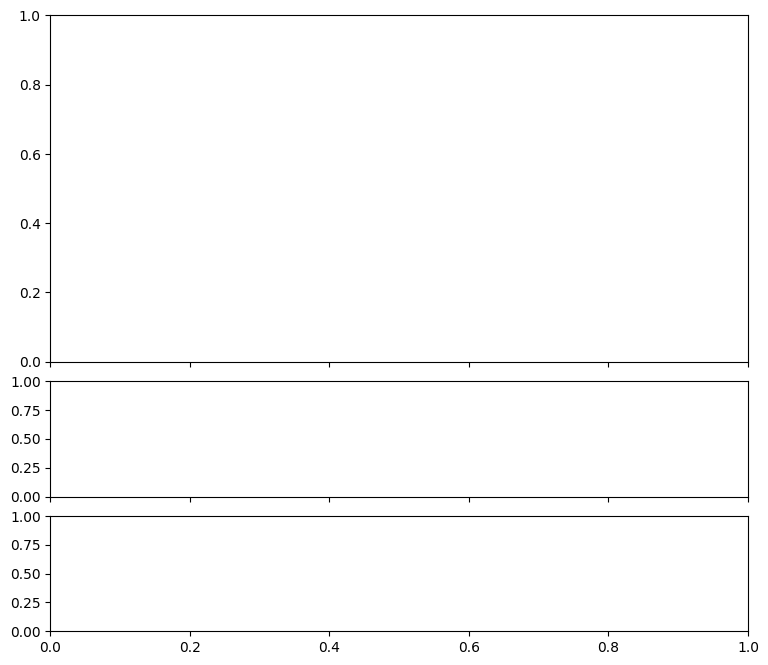

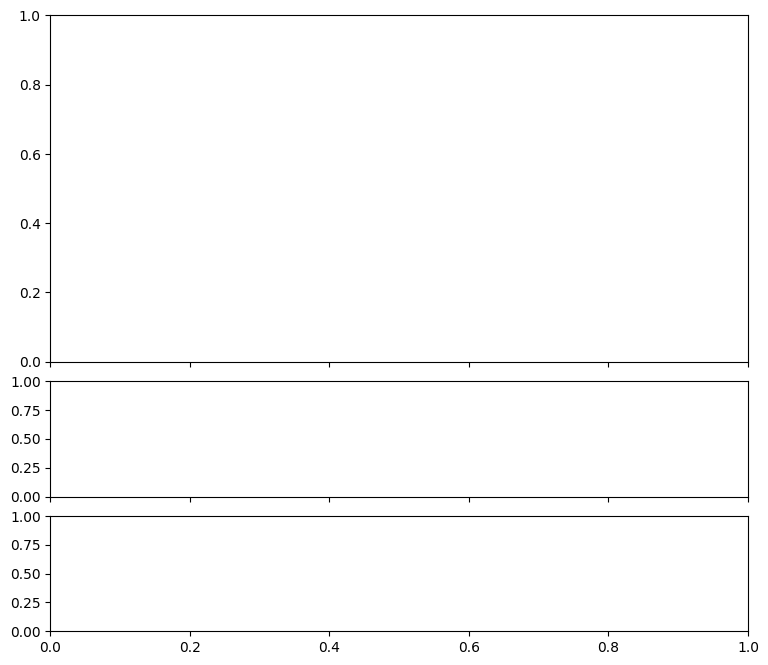

In [8]:
model.plot_to_pdf(
    	output_dir = 'output_Toy_dataset_2a/',
    	bin_widths_1d = bin_widths_1d,
    	#bin_edges_2d = bin_edges_2d,
    	plot_logy = False,
    	plot_logx = False,
        sampling_95quantile = False
)